** Project - Testing for the difference in means between three different exchange traded funds that follow the ESG framwework **

1. Prior to the period of greatest volatility. Is there a significant difference in the means of daily returns between the three different Exchange Traded Funds?
2. During the period of greatest volatility. Is there a significant difference in the means of daily returns between the three different Exchange Traded Funds?
3. If there is any significant difference, how large was this difference and  in which period?

|Ticker Name                       |              Meaning                |
|----------------------------------|-------------------------------------|
|     ESGE ~ ESG MSCI EM ETF       | Emerging Markets ESG                |
|     ESGD ~ ESG MSCI EAFE ETF     | Europe, Australia, Far East ESG     |
|     ESGU ~ ESG MSCI USA ETF      | U.S.A. ESG                          | 
|     ^VIX                         | Volatility Index                    |

In [1]:
# Setting up the enviroment
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
import pylab
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [2]:
# Bringing the datasets into the notebook
esge = pd.read_csv('Datasets/ESGE.csv')
esgd = pd.read_csv('Datasets/ESGD.csv')
esgu = pd.read_csv('Datasets/ESGU.csv')
vix = pd.read_csv('Datasets/^vix.csv')

print('ESGE shape: ', esge.shape)
print('ESGD shape: ', esgd.shape)
print('ESGU shape: ', esgu.shape)
print('vix shape: ', vix.shape)

ESGE shape:  (1006, 7)
ESGD shape:  (993, 7)
ESGU shape:  (922, 7)
vix shape:  (1007, 7)


In [3]:
# Exploring the first rows of the ESGE dataset
esge.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,28.295,28.295,28.295,28.295,26.197134,400
1,2016-08-09,28.490,28.490,28.468,28.468,26.357309,1400
2,2016-08-10,28.580,28.580,28.580,28.580,26.461002,200


In [4]:
# Exploring the first rows of the ESGD dataset
esgd.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-25,56.540001,56.540001,56.540001,56.540001,51.682915,100
1,2016-08-26,56.540001,56.540001,56.540001,56.540001,51.682915,0
2,2016-08-29,56.270000,56.270000,56.258999,56.259998,51.426964,2600


In [5]:
# Exploring the first rows of the ESGU dataset
esgu.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-06,48.259998,48.259998,48.259998,48.259998,45.492722,100
1,2016-12-07,48.259998,48.259998,48.259998,48.259998,45.492722,0
2,2016-12-08,48.259998,48.259998,48.259998,48.259998,45.492722,0


In [6]:
# Exploring the first rows of the VIX dataset
vix.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,11.66,11.78,11.41,11.50,11.50,0
1,2016-08-09,11.40,11.92,11.02,11.66,11.66,0
2,2016-08-10,11.55,12.50,11.37,12.05,12.05,0


In [7]:
# Converting the Date columns into date type
esge['Date'] = pd.to_datetime(esge['Date'])
esgd['Date'] = pd.to_datetime(esgd['Date'])
esgu['Date'] = pd.to_datetime(esgu['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])

In [8]:
# Setting the date column as the index 
esge.set_index(esge['Date'], inplace=True)
esgd.set_index(esgd['Date'], inplace=True)
esgu.set_index(esgu['Date'], inplace=True)
vix.set_index(vix['Date'], inplace=True)

In [9]:
# Creating a new column named "Daily Returns" with the calculated daily returns using the open and adjusted close price.
esge['Daily Returns ESGE'] = esge['Adj Close'] / esge['Adj Close'].shift(1) - 1
esgd['Daily Returns ESGD'] = esgd['Adj Close'] / esgd['Adj Close'].shift(1) - 1
esgu['Daily Returns ESGU'] = esgu['Adj Close'] / esgu['Adj Close'].shift(1) - 1
vix['Daily Change VIX'] = vix['Adj Close'] / vix['Adj Close'].shift(1) - 1

In [10]:
# Combinig the four dailiy return columns into one dataframe:
esge_daily = esge['Daily Returns ESGE']
esgd_daily = esgd['Daily Returns ESGD']
esgu_daily = esgu['Daily Returns ESGU']
vix_daily = vix['Daily Change VIX']

daily_returns_df = pd.concat([esge_daily, esgd_daily, esgu_daily, vix_daily], axis=1)
daily_returns_df.head()

,Daily Returns ESGE,Daily Returns ESGD,Daily Returns ESGU,Daily Change VIX
Date,,,,
2016-08-08,NaN,NaN,NaN,NaN
2016-08-09,0.006114,NaN,NaN,0.013913
2016-08-10,0.003934,NaN,NaN,0.033448
2016-08-11,0.004724,NaN,NaN,-0.030705
2016-08-12,0.000000,NaN,NaN,-0.011130


In [11]:
# Checking for the total number of NaN values in the dataframe:
daily_returns_df.isna().sum()

Daily Returns ESGE     2
Daily Returns ESGD    15
Daily Returns ESGU    86
Daily Change VIX       1
dtype: int64

In [12]:
# Replacing NaN values with zeros instead of deleting them:
daily_returns_df.fillna(0, axis=1, inplace=True)
daily_returns_df.head()

,Daily Returns ESGE,Daily Returns ESGD,Daily Returns ESGU,Daily Change VIX
Date,,,,
2016-08-08,0.000000,0.0,0.0,0.000000
2016-08-09,0.006114,0.0,0.0,0.013913
2016-08-10,0.003934,0.0,0.0,0.033448
2016-08-11,0.004724,0.0,0.0,-0.030705
2016-08-12,0.000000,0.0,0.0,-0.011130


In [13]:
# Creating three different series with the average daily price for each ETF
esge['Avg Daily Price'] = (esge['High'] + esge['Low']) / 2
esgd['Avg Daily Price'] = (esgd['High'] + esgd['Low']) / 2
esgu['Avg Daily Price'] = (esgu['High'] + esgu['Low']) / 2

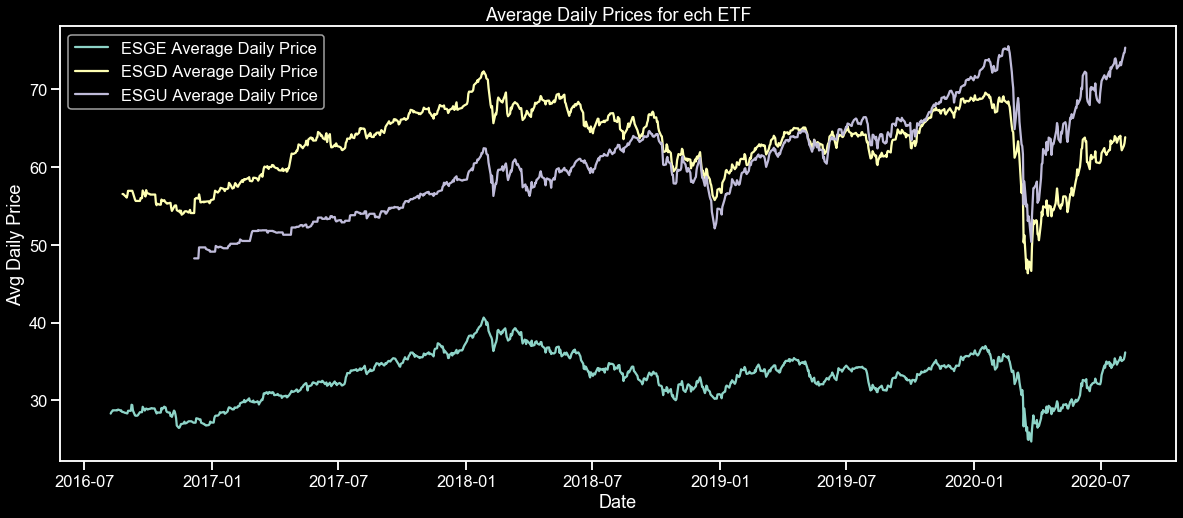

In [14]:
# Plotting the different average dailiy prices for each ETF:
plt.figure(figsize=(20,8))
sns.lineplot(x = esge.index, y = esge['Avg Daily Price'])
sns.lineplot(x = esgd.index, y = esgd['Avg Daily Price'])
sns.lineplot(x = esgu.index, y = esgu['Avg Daily Price'])
plt.legend(labels=['ESGE Average Daily Price', 'ESGD Average Daily Price', 'ESGU Average Daily Price'])
plt.title('Average Daily Prices for ech ETF')
plt.savefig('prices')
plt.show()

In [15]:
# From the previous chart we can see a common trend between the three ETF´s, which suggests a correlation between them.
# Checking for the correlations between the four different returns:
corr_matrix = daily_returns_df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Daily Returns ESGE,Daily Returns ESGD,Daily Returns ESGU,Daily Change VIX
Daily Returns ESGE,1.000000,0.839141,0.754810,-0.587733
Daily Returns ESGD,0.839141,1.000000,0.854945,-0.611633
Daily Returns ESGU,0.754810,0.854945,1.000000,-0.584727
Daily Change VIX,-0.587733,-0.611633,-0.584727,1.000000


From the correlation plot we can observe the following two points:
1. The three different ETF's are strongly positively correlated 
2. The three different ETF's are strongly negatively correlated with the daily change of the VIX 

The next step in the analysis is to evaluate the period where the VIX has increased the most in order to split the dataset into two different periods, one prior to the high volatility period and another during this period of high volatility. 

In [16]:
# Creating a new column in the VIX dataframe that contains the average between the High and Low price for each day
vix['Avg Daily Price'] = (vix['High'] + vix['Low']) / 2
vix['Avg Daily Price'].head()

Date
2016-08-08    11.595
2016-08-09    11.470
2016-08-10    11.935
2016-08-11    11.745
2016-08-12    11.640
Name: Avg Daily Price, dtype: float64

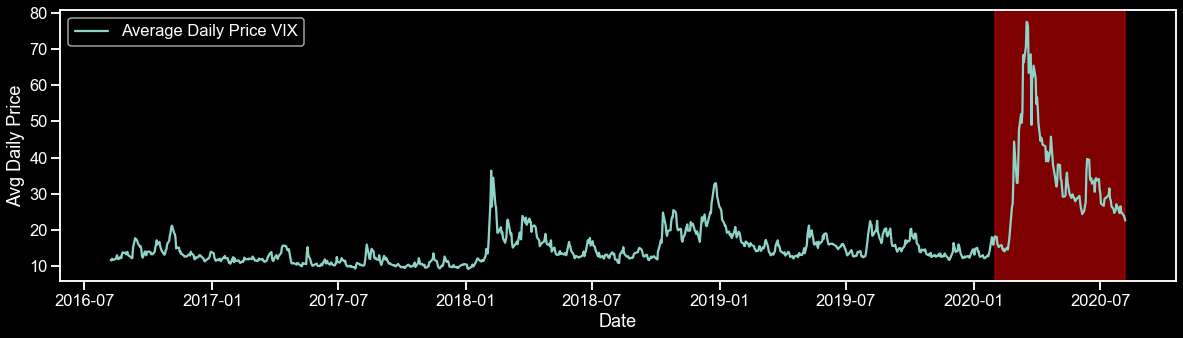

In [17]:
# Plotting the volatility index (VIX) average price to look for the period with the greatest volatility
plt.figure(figsize=(20,5))
sns.lineplot(x = vix.index, y = vix['Avg Daily Price'])
plt.legend(labels = ['Average Daily Price VIX'])
plt.axvspan(*mdates.datestr2num(['2020-01-31', '2020-08-06']), color='red', alpha=0.5)
plt.savefig('Volatility')
plt.show()

From this chart we can conclude that the period with the greatest volatility was from the beginning of Febraury 2020 to the end of our observations, August 2020.

Next step is to divide each dataset into two different periods:

 -One from the first observation to Febrary 2020.
 
 -Another from February 2020 to the last observation.

In [18]:
# This will be the first period dataframe
first_period_df = daily_returns_df.loc['2016-08-08':'2020-01-31']
first_period_df.shape

(877, 4)

In [19]:
first_period_df.head(1)

,Daily Returns ESGE,Daily Returns ESGD,Daily Returns ESGU,Daily Change VIX
Date,,,,
2016-08-08,0.0,0.0,0.0,0.0


In [20]:
# This will be the second period dataframe
second_period_df = daily_returns_df.loc['2020-02-01':'2020-08-06']
second_period_df.shape

(130, 4)

The next step in the analysis is to check the daily return distribution for each instrument in the first period.

For this we will plot each ditribution as well as stats.describe.

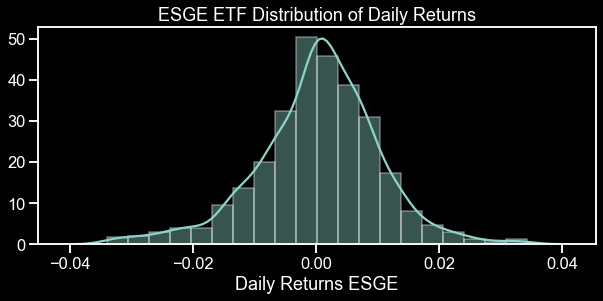

ESGE ETF Daily Returns Statistics:  DescribeResult(nobs=877, minmax=(-0.03405565448153769, 0.03433749581800827), mean=0.00033765706814595643, variance=9.909865840165369e-05, skewness=-0.32726307343779687, kurtosis=1.1662981427578192)


In [21]:
# Checking for normality of distrubution; first period - ESGE:
plt.figure(figsize=(10,4))
sns.distplot(first_period_df['Daily Returns ESGE'], kde=True, bins=20)
plt.title('ESGE ETF Distribution of Daily Returns')
plt.show()
print('ESGE ETF Daily Returns Statistics: ', stats.describe(first_period_df['Daily Returns ESGE']))

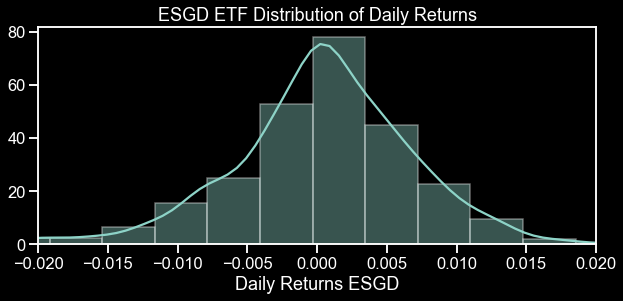

ESGD ETF Daily Returns Statistics:  DescribeResult(nobs=877, minmax=(-0.04180999629656712, 0.033629070923991256), mean=0.00030788004283751485, variance=5.0177156702758704e-05, skewness=-0.48168248189233875, kurtosis=3.3753186320771507)


In [22]:
# Checking for normality of distrubution; first period - ESGD:
plt.figure(figsize=(10,4))
sns.distplot(first_period_df['Daily Returns ESGD'], kde=True, bins=20)
plt.title('ESGD ETF Distribution of Daily Returns')
plt.xlim(-0.02, 0.02)
plt.show()
print('ESGD ETF Daily Returns Statistics: ', stats.describe(first_period_df['Daily Returns ESGD']))

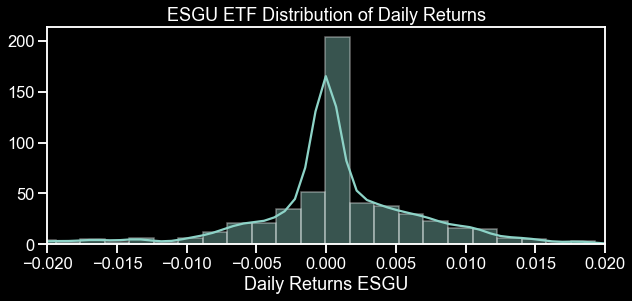

ESGU ETF Daily Returns Statistics:  DescribeResult(nobs=877, minmax=(-0.03694470824054874, 0.05089362813608034), mean=0.0005397585301723985, variance=5.85607168317813e-05, skewness=-0.2842859238527884, kurtosis=6.15970561270988)


In [23]:
# Checking for normality of distrubution; first period - ESGU:
plt.figure(figsize=(10,4))
sns.distplot(first_period_df['Daily Returns ESGU'], kde=True, bins=50)
plt.title('ESGU ETF Distribution of Daily Returns')
plt.xlim(-0.02, 0.02)
plt.show()
print('ESGU ETF Daily Returns Statistics: ', stats.describe(first_period_df['Daily Returns ESGU']))

From the different distribution plots we can observe the following:

1. The kurtosis and skewness of the ESGE ETF distribution seems to follow a normal distribution.
2. The skewness of the ESGD ETF distribution also seems to follow a normal one, although the kurtosis of 3.37 it's a little bit high.
3. The kurtosis of the ESGU ETF seems to be a little vit high, further exploration will be needed.

Next step is to create qq plots and run a shapiro test for each ETF daily return for the first period in order to further analyze the normality of returns.

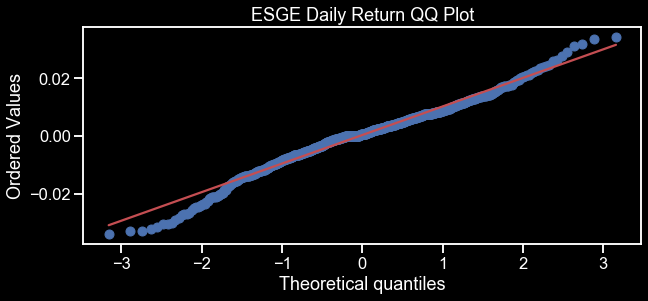

In [49]:
# Creating a qqplot; first period - ESGE
plt.figure(figsize=(10,4))
stats.probplot(first_period_df['Daily Returns ESGE'], dist='norm', plot=plt)
plt.title('ESGE Daily Return QQ Plot')
plt.show()

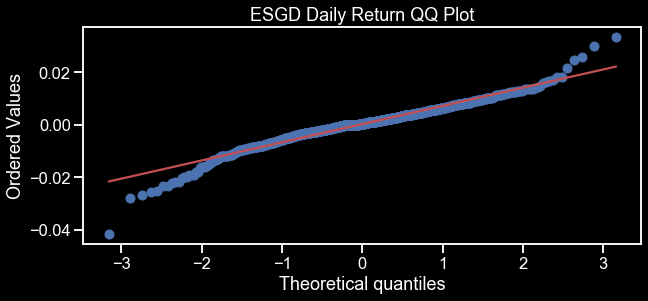

In [50]:
# Creating a qqplot; first period - ESGD
plt.figure(figsize=(10,4))
stats.probplot(first_period_df['Daily Returns ESGD'], dist='norm', plot=plt)
plt.title('ESGD Daily Return QQ Plot')
plt.show()

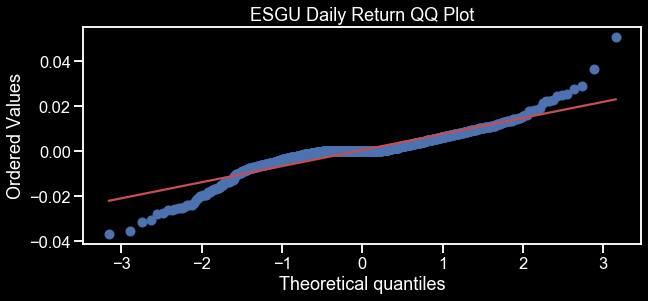

In [52]:
# Creating a qqplot; first period - ESGU
plt.figure(figsize=(10,4))
stats.probplot(first_period_df['Daily Returns ESGU'], dist='norm', plot=plt)
plt.title('ESGU Daily Return QQ Plot')
plt.show()

From the QQ plots we can conclude that the three ETF's  different distributions of daily returns for the first period approximate a normal distribution.

The next step is to repeat the previous analysis, this time for the second period.

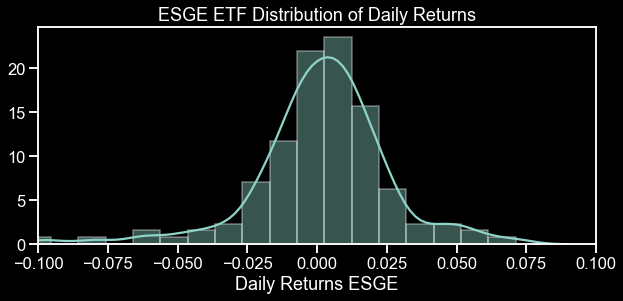

ESGE ETF Daily Returns Statistics:  DescribeResult(nobs=130, minmax=(-0.12482948585627429, 0.07124589899963563), mean=0.0009018162655070699, variance=0.0007110159901045052, skewness=-1.2450468278778755, kurtosis=4.892346775947963)


In [27]:
# Checking for normality of distrubution; second period - ESGE:
plt.figure(figsize=(10,4))
sns.distplot(second_period_df['Daily Returns ESGE'], kde=True, bins=20)
plt.title('ESGE ETF Distribution of Daily Returns')
plt.xlim(-0.10,0.10)
plt.show()
print('ESGE ETF Daily Returns Statistics: ', stats.describe(second_period_df['Daily Returns ESGE']))

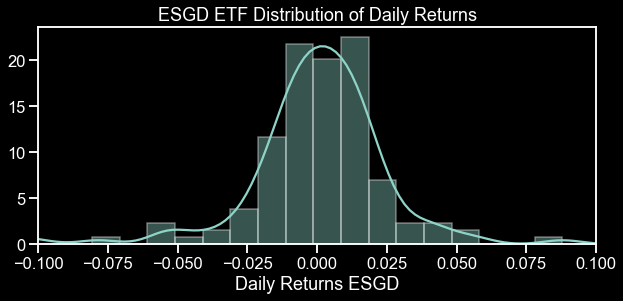

ESGD ETF Daily Returns Statistics:  DescribeResult(nobs=130, minmax=(-0.11037333287957618, 0.08795494258276282), mean=2.170913829694707e-05, variance=0.0006413444118300154, skewness=-1.0226943549428804, kurtosis=5.024242993297037)


In [28]:
# Checking for normality of distrubution; second period - ESGD:
plt.figure(figsize=(10,4))
sns.distplot(second_period_df['Daily Returns ESGD'], kde=True, bins=20)
plt.title('ESGD ETF Distribution of Daily Returns')
plt.xlim(-0.10,0.10)
plt.show()
print('ESGD ETF Daily Returns Statistics: ', stats.describe(second_period_df['Daily Returns ESGD']))

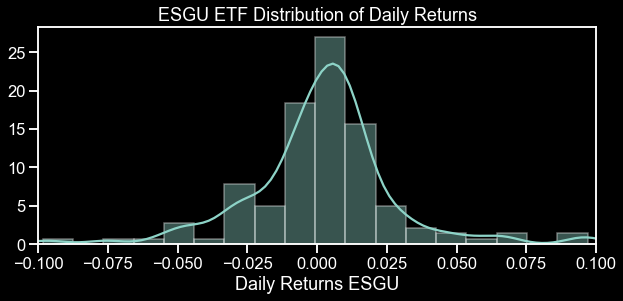

ESGU ETF Daily Returns Statistics:  DescribeResult(nobs=130, minmax=(-0.1200264641511406, 0.09693873577117351), mean=0.0008574489753952227, variance=0.0008153983174807177, skewness=-0.41876585744587685, kurtosis=4.198794269332047)


In [29]:
# Checking for normality of distrubution; second period - ESGU:
plt.figure(figsize=(10,4))
sns.distplot(second_period_df['Daily Returns ESGU'], kde=True, bins=20)
plt.title('ESGU ETF Distribution of Daily Returns')
plt.xlim(-0.10,0.10)
plt.show()
print('ESGU ETF Daily Returns Statistics: ', stats.describe(second_period_df['Daily Returns ESGU']))

From the different distribution plots we can observe the following:

1. The kurtosis of the three different distributions seems to be high. Which suggests a leptokurtic distribution for each one in the second period.

Next step is to create qq plots and run shapiro tests for each ETF daily return for the first period in order to further analyze the normality of returns.

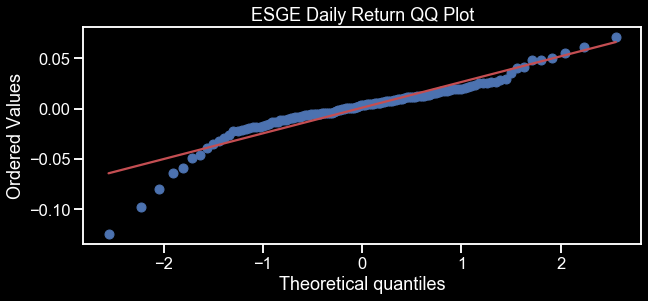

In [53]:
# Creating a qqplot; second period - ESGE
plt.figure(figsize=(10,4))
stats.probplot(second_period_df['Daily Returns ESGE'], dist='norm', plot=plt)
plt.title('ESGE Daily Return QQ Plot')
plt.show()

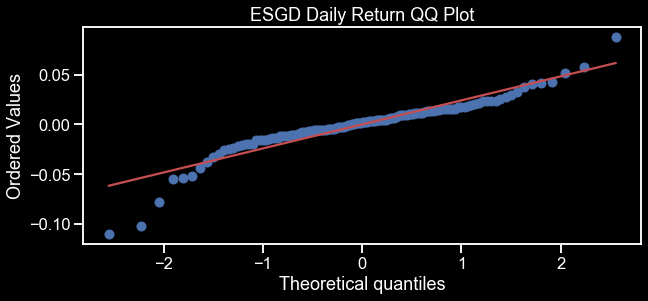

In [55]:
# Creating a qqplot; second period - ESGD
plt.figure(figsize=(10,4))
stats.probplot(second_period_df['Daily Returns ESGD'], dist='norm', plot=plt)
plt.title('ESGD Daily Return QQ Plot')
plt.show()

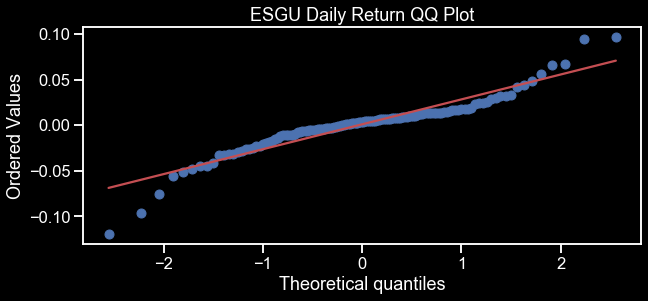

In [56]:
# Creating a qqplot; second period - ESGU
plt.figure(figsize=(10,4))
stats.probplot(second_period_df['Daily Returns ESGU'], dist='norm', plot=plt)
plt.title('ESGU Daily Return QQ Plot')
plt.show()

From the QQ plots we can conclude that the three ETF's  different distributions of daily returns for the second period does approximate a normal distribution.


The next step of the analysis is to perform a Repeated Measures ANOVA test for dependent variables in order to answer the following questions about our data:
1. Prior to the period of greatest volatility. Is there a significant difference in the means of daily returns between the three different Exchange Traded Funds?
2. During the period of greatest volatility. Is there a significant difference in the means of daily returns between the three different Exchange Traded Funds?
3. If there is any significant difference, how large was this difference and  in which period?

In [33]:
# The first step is to apply a melt function to the first period dataframe:
first_period_df = first_period_df.drop(['Daily Change VIX'], axis=1)
first_period_df['Date'] = first_period_df.index
first_melt = pd.melt(first_period_df, id_vars='Date', var_name="Index", value_name="Return")
first_melt.head(5)

,Date,Index,Return
0,2016-08-08,Daily Returns ESGE,0.000000
1,2016-08-09,Daily Returns ESGE,0.006114
2,2016-08-10,Daily Returns ESGE,0.003934
3,2016-08-11,Daily Returns ESGE,0.004724
4,2016-08-12,Daily Returns ESGE,0.000000


In [34]:
# Performing the repeated measures ANOVA test for the first period:
anova = AnovaRM(data = first_melt, depvar = 'Return', subject = 'Index', within = ['Date']).fit()
anova.summary()

,F Value,Num DF,Den DF,Pr > F
Date,6.5698,876.0000,1752.0000,0.0000


According to the P Value of 0:

We see evidence that at least one of the daily return means of the three different ETF's in the first period is significantly different.

In [35]:
# Applying the melt function to the second period dataframe:
second_period_df = second_period_df.drop(['Daily Change VIX'], axis=1)
second_period_df['Date'] = second_period_df.index
second_melt = pd.melt(second_period_df, id_vars='Date', var_name="Index", value_name="Return")
second_melt.head(5)

,Date,Index,Return
0,2020-02-03,Daily Returns ESGE,0.011487
1,2020-02-04,Daily Returns ESGE,0.025917
2,2020-02-05,Daily Returns ESGE,0.006245
3,2020-02-06,Daily Returns ESGE,0.000282
4,2020-02-07,Daily Returns ESGE,-0.015792


In [36]:
# Performing the repeated measures ANOVA test for the second period:
anova = AnovaRM(data = second_melt, depvar = 'Return', subject = 'Index', within = ['Date']).fit()
anova.summary()

,F Value,Num DF,Den DF,Pr > F
Date,31.3194,129.0000,258.0000,0.0000


Interpretation of results:


According to the P Value of 0:

We see evidence that at least one of the daily return means of the three different ETF's in the second period is significantly different.

Next step is to analyze the mean and standard deviation for each ETF in each period

In [37]:
# Analyzing the mean and standard deviation for ESGE in the first period:
mean_esge_1p = first_period_df['Daily Returns ESGE'].mean()
std_esge_1p = first_period_df['Daily Returns ESGE'].std()

In [44]:
# Analyzing the mean and standard deviation for ESGD in the first period:
mean_esgd_1p = first_period_df['Daily Returns ESGD'].mean()
std_esgd_1p = first_period_df['Daily Returns ESGD'].std()

In [45]:
# Analyzing the mean and standard deviation for ESGU in the first period:
mean_esgu_1p = first_period_df['Daily Returns ESGU'].mean()
std_esgu_1p = first_period_df['Daily Returns ESGU'].std()

In [68]:
# Creating a dataframe with the different means values:
means_first_period = pd.DataFrame({'ETFs':['Mean of ESGE', 'Mean of ESGD', 'Mean of ESGU'], 'Daily Return Means': [mean_esge_1p, mean_esgd_1p, mean_esgu_1p]})
means_first_period

,ETFs,Daily Return Means
0,Mean of ESGE,0.000338
1,Mean of ESGD,0.000308
2,Mean of ESGU,0.000540


In [80]:
# Creating a dataframe with the different standard deviation values:
std_first_period = pd.DataFrame({'ETFs':['Std of ESGE', 'Std of ESGD', 'Std of ESGU'], 'Daily Return Standard Deviations': [std_esge_1p, std_esgd_1p, std_esgu_1p]})
std_first_period

,ETFs,Daily Return Standard Deviations
0,Std of ESGE,0.009955
1,Std of ESGD,0.007084
2,Std of ESGU,0.007652


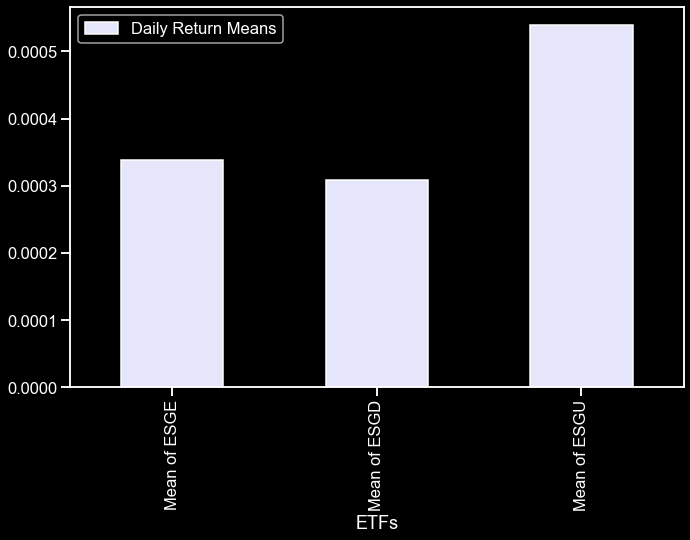

In [132]:
# Creating a bar chart for each variable in the first period:
ax1 = means_first_period.plot.bar(x = 'ETFs', y = 'Daily Return Means', figsize=(11,7), color = 'lavender')

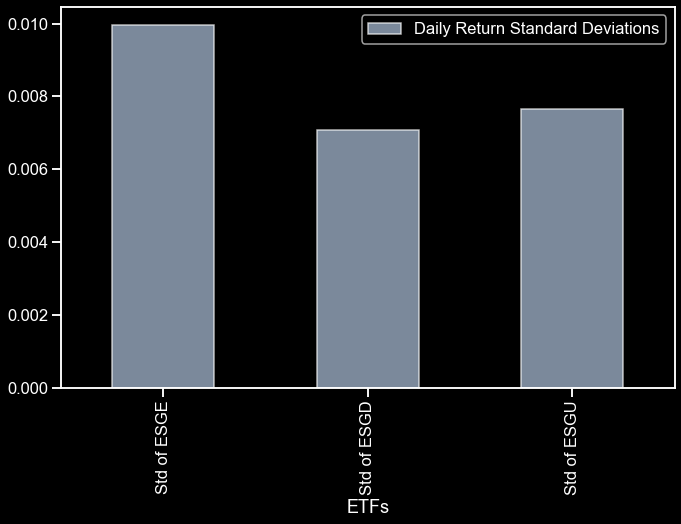

In [135]:
ax2 = std_first_period.plot.bar(x = 'ETFs', y = 'Daily Return Standard Deviations', figsize=(11,7), color = 'lightsteelblue', alpha = 0.7)

From this graphs we can observe the following:

The ESGU ETF daily return is the one that is significantly different from the others, and for the same measure of risk it seems that it outperforms 
both the ESGE and the ESGD ETFs (as measured by the daily mean return).

Next step is to repeat the same analysis for the second period:

In [136]:
# Analyzing the mean and standard deviation for ESGE in the second period:
mean_esge_2p = second_period_df['Daily Returns ESGE'].mean()
std_esge_2p = second_period_df['Daily Returns ESGE'].std()

In [137]:
# Analyzing the mean and standard deviation for ESGD in the second period:
mean_esgd_2p = second_period_df['Daily Returns ESGD'].mean()
std_esgd_2p = second_period_df['Daily Returns ESGD'].std()

In [138]:
# Analyzing the mean and standard deviation for ESGU in the second period:
mean_esgu_2p = second_period_df['Daily Returns ESGU'].mean()
std_esgu_2p = second_period_df['Daily Returns ESGU'].std()

In [140]:
# Creating a dataframe with the different means values:
means_second_period = pd.DataFrame({'ETFs':['Mean of ESGE', 'Mean of ESGD', 'Mean of ESGU'], 'Daily Return Means': [mean_esge_2p, mean_esgd_2p, mean_esgu_2p]})
means_second_period

,ETFs,Daily Return Means
0,Mean of ESGE,0.000902
1,Mean of ESGD,0.000022
2,Mean of ESGU,0.000857


In [141]:
# Creating a dataframe with the different standard deviation values:
std_second_period = pd.DataFrame({'ETFs':['Std of ESGE', 'Std of ESGD', 'Std of ESGU'], 'Daily Return Standard Deviations': [std_esge_2p, std_esgd_2p, std_esgu_2p]})
std_second_period

,ETFs,Daily Return Standard Deviations
0,Std of ESGE,0.026665
1,Std of ESGD,0.025325
2,Std of ESGU,0.028555


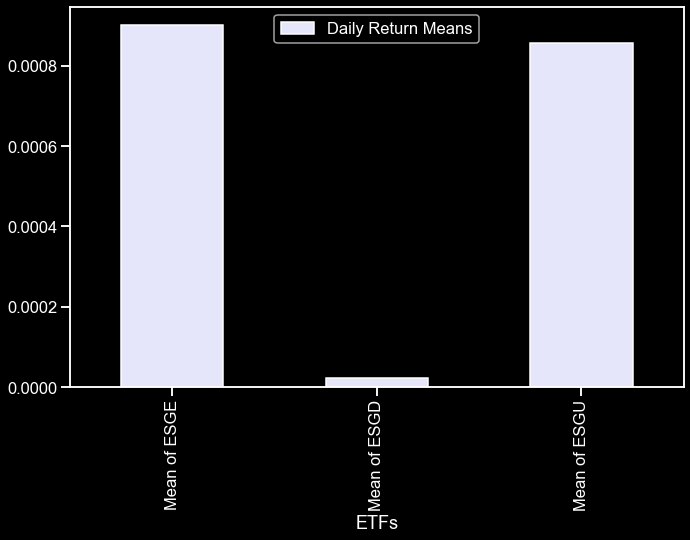

In [142]:
# Creating a bar chart for each variable in the second period:
ax1 = means_second_period.plot.bar(x = 'ETFs', y = 'Daily Return Means', figsize=(11,7), color = 'lavender')

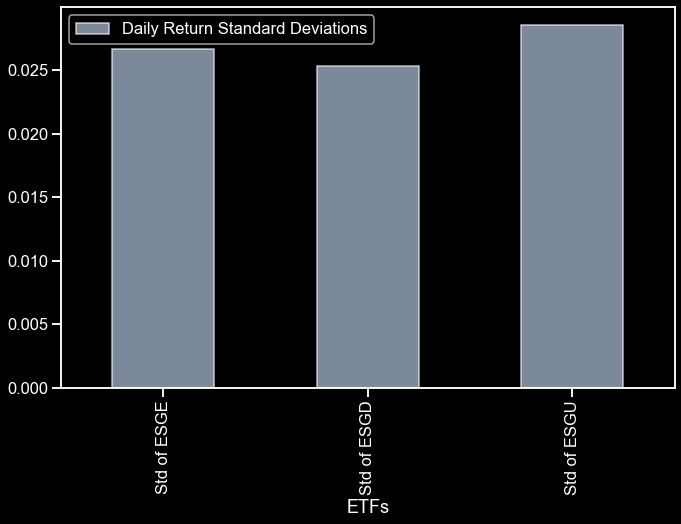

In [144]:
ax2 = std_second_period.plot.bar(x = 'ETFs', y = 'Daily Return Standard Deviations', figsize=(11,7), color = 'lightsteelblue', alpha = 0.7)

From this graphs we can observe the following:

The ESGD daily return mean is the one that is significantly different from the others, we can see that the daily return for this ETF has underperformed the daily
mean returns of the other ETFs.

We can also observe that the risk, as measured by the standard deviation, more than tripled during this period.